In [ ]:
# Install the main libraries for our models
!pip install -q xgboost
!pip install -q tensorflow

In [ ]:
import pandas as pd
import numpy as np
import joblib  # For saving our model and scaler

# Preprocessing and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Models
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# For downloading files from Colab
from google.colab import files

In [ ]:
# 1. Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

data = pd.read_csv(url, header=None, names=column_names)

print("--- Initial Data (first 5 rows) ---")
print(data.head())

# 2. Clean the data
# The dataset uses '?' for missing values.
data.replace('?', np.nan, inplace=True)

# Drop rows with any missing values
data.dropna(inplace=True)

# Convert all columns to numeric
data = data.astype(float)

# 3. Prepare features (X) and target (y)
# The 'target' column is 0 for no disease, and 1,2,3,4 for disease
# We need to make this a binary (0 or 1) problem
data['target'] = (data['target'] > 0).astype(int)

print("\n--- Cleaned Data (first 5 rows) ---")
print(data.head())
print(f"\nData shape after cleaning: {data.shape}")
print("\nTarget value counts:")
print(data['target'].value_counts())

X = data.drop('target', axis=1)
y = data['target']

--- Initial Data (first 5 rows) ---
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  

--- Cleaned Data (first 5 rows) ---
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0  

In [ ]:
# 1. Scale the features
# This is critical for neural networks
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Save the scaler
# We MUST save the *same* scaler used for training to use it in production
joblib.dump(scaler, 'scaler.joblib')
print("Scaler saved as 'scaler.joblib'")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Scaler saved as 'scaler.joblib'

Training data shape: (237, 13)
Testing data shape: (60, 13)


In [ ]:
print("--- Training XGBoost Model ---")

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# --- Evaluation ---
print("\n--- XGBoost Test Results ---")
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

--- Training XGBoost Model ---

--- XGBoost Test Results ---
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        32
           1       0.85      0.79      0.81        28

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:45:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
print("--- Training Keras ANN Model ---")
n_features = X_train.shape[1] # Should be 13

ann_model = Sequential()
ann_model.add(Dense(128, activation='relu', input_shape=(n_features,)))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(1, activation='sigmoid')) # Sigmoid for binary output

ann_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = ann_model.fit(
    X_train, y_train,
    epochs=100,  # You can see the training progress!
    batch_size=10,
    validation_split=0.2,
    verbose=1
)

# --- Evaluation ---
print("\n--- Keras ANN Test Results ---")
# Predict probabilities (e.g., 0.85)
y_pred_ann_probs = ann_model.predict(X_test)
# Convert probabilities to classes (0 or 1)
y_pred_ann = (y_pred_ann_probs > 0.5).astype(int).reshape(-1)

print(classification_report(y_test, y_pred_ann))

--- Training Keras ANN Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5786 - loss: 0.7132 - val_accuracy: 0.7083 - val_loss: 0.5837
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8337 - loss: 0.4826 - val_accuracy: 0.7708 - val_loss: 0.5381
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8064 - loss: 0.4394 - val_accuracy: 0.7708 - val_loss: 0.5309
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8907 - loss: 0.3306 - val_accuracy: 0.7083 - val_loss: 0.5516
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8598 - loss: 0.3205 - val_accuracy: 0.7083 - val_loss: 0.5750
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8534 - loss: 0.3387 - val_accuracy: 0.6875 - val_loss: 0.6016
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8624 - loss: 0.3189 - val_accuracy: 0.7292 - val_loss: 0.6248
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8821 - loss: 0.2884 - val_accuracy: 0.7083 - 

In [ ]:
# Add these to your import cell
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

--- Confusion Matrices ---


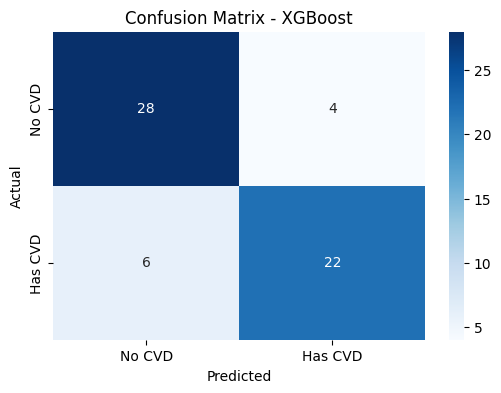

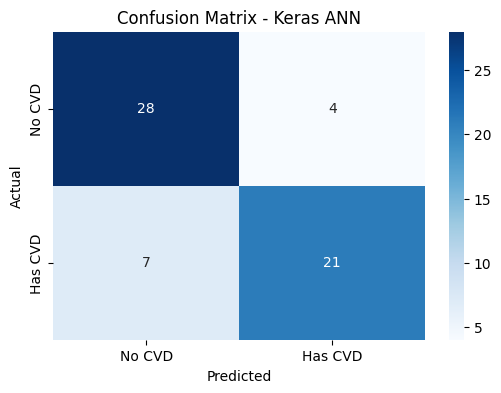

In [ ]:
# We'll create a helper function to make plotting easy
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No CVD', 'Has CVD'],
                yticklabels=['No CVD', 'Has CVD'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot for both models
print("--- Confusion Matrices ---")
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost")
plot_confusion_matrix(y_test, y_pred_ann, "Keras ANN")

--- ROC (Receiver Operating Characteristic) Curve ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


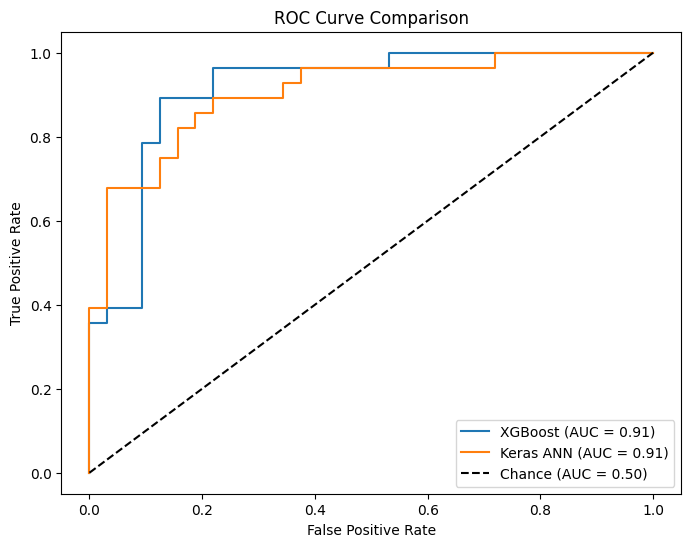

In [ ]:
print("--- ROC (Receiver Operating Characteristic) Curve ---")

# Get prediction probabilities for ROC curve
# XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
# ANN (it already gives probabilities)
y_prob_ann = ann_model.predict(X_test).ravel() # .ravel() flattens the array

# Calculate ROC curve data
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
auc_ann = auc(fpr_ann, tpr_ann)

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'Keras ANN (AUC = {auc_ann:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # Dotted baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

--- XGBoost Feature Importance ---


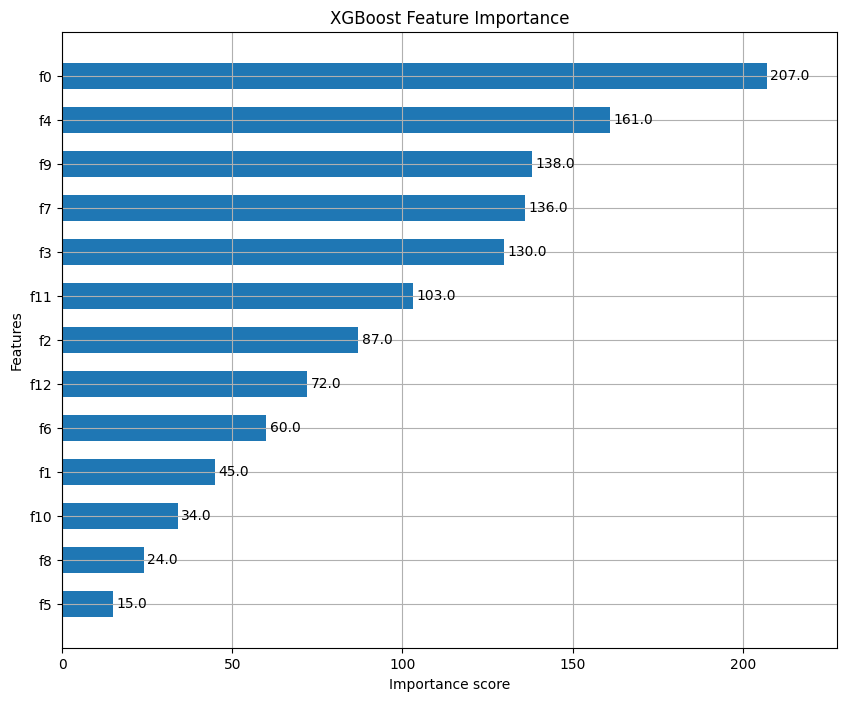

In [ ]:
print("--- XGBoost Feature Importance ---")

# Use the built-in XGBoost plotting function
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_model, ax=ax, height=0.6)
plt.title('XGBoost Feature Importance')
plt.show()

--- ANN Training & Validation History ---


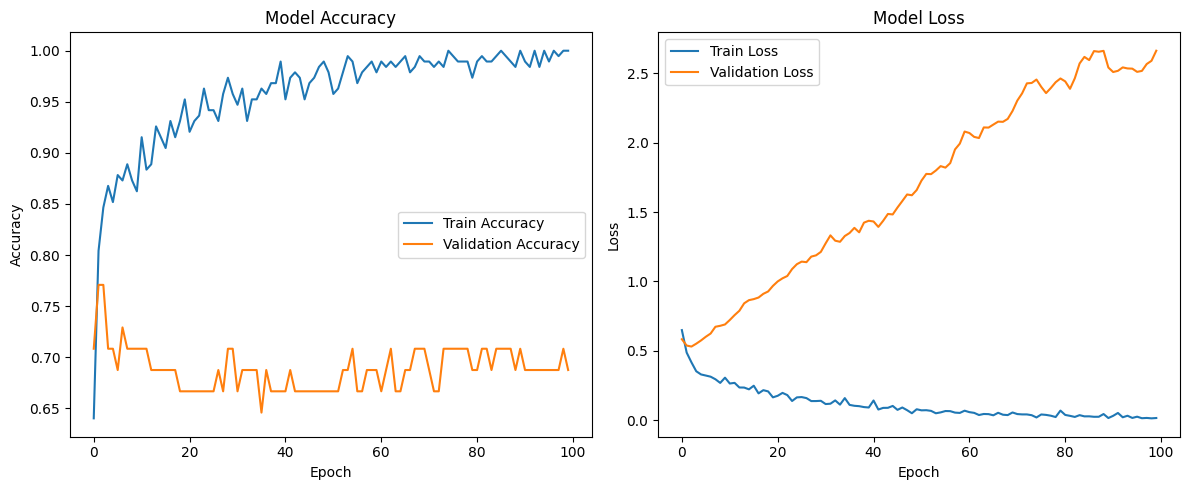

In [ ]:
print("--- ANN Training & Validation History ---")

# The 'history' object was saved when we ran .fit()
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# --- Save the Winning Model ---
# We'll save the XGBoost model
joblib.dump(xgb_model, 'cvd_model.joblib')
print("Winner (XGBoost) saved as 'cvd_model.joblib'")


# --- Download Your Files ---
# This is the most 'Colab-specific' part.
# This will trigger two download prompts in your browser.
print("\nDownloading model and scaler...")
files.download('cvd_model.joblib')
files.download('scaler.joblib')


Winner (XGBoost) saved as 'cvd_model.joblib'



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

print("--- Starting Hyperparameter Tuning for XGBoost ---")

# 1. Define the parameter grid to search
# These are some of the most important settings for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300, 400],           # Number of trees
    'max_depth': [3, 4, 5, 6, 7],                   # Max depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],        # How fast the model learns
    'subsample': [0.7, 0.8, 0.9, 1.0],              # % of data used per tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]        # % of features used per tree
}

# 2. Initialize the base model
# We use the base XGBClassifier without any custom settings
base_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 3. Set up the Randomized Search
# n_iter=50 means it will try 50 different random combinations.
# cv=5 means it will use 5-fold cross-validation (very robust).
# scoring='recall' tells it our main goal is maximizing recall.
# n_jobs=-1 uses all available CPU cores in Colab to speed it up.
random_search = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='recall',  # We are optimizing for RECALL!
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4. Run the search on the training data
random_search.fit(X_train, y_train)

# 5. Print the best findings
print("\n--- Tuning Complete ---")
print(f"Best Recall Score found: {random_search.best_score_:.4f}")
print("Best Hyperparameters found:")
print(random_search.best_params_)

# 6. Get the best model
best_xgb_model = random_search.best_estimator_

--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Tuning Complete ---
Best Recall Score found: 0.7970
Best Hyperparameters found:
{'subsample': 0.7, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:52:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluating the NEW Tuned XGBoost Model ---
Tuned XGBoost Test Results:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.89      0.86      0.87        28

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



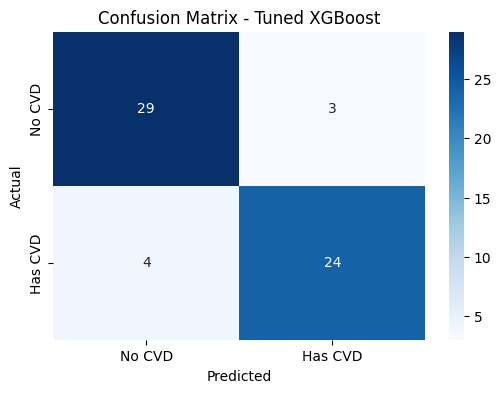


Saving the *new* tuned model as 'cvd_model.joblib'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("\n--- Evaluating the NEW Tuned XGBoost Model ---")

# Evaluate the new best model on the test set
y_pred_tuned_xgb = best_xgb_model.predict(X_test)

print("Tuned XGBoost Test Results:")
print(classification_report(y_test, y_pred_tuned_xgb))

# Plot its new confusion matrix
plot_confusion_matrix(y_test, y_pred_tuned_xgb, "Tuned XGBoost")

# --- SAVE THE FINAL, OPTIMIZED MODEL ---
print("\nSaving the *new* tuned model as 'cvd_model.joblib'")

# We overwrite the old, untuned model with our new, better one
joblib.dump(best_xgb_model, 'cvd_model.joblib')

# Remember to also download the scaler again if you don't have it
# files.download('scaler.joblib')
files.download('cvd_model.joblib')

In [ ]:
import pandas as pd

print("--- Running Robustness & Sanity Checks ---")

# We need the original feature names from our dataset
feature_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# --- Case 1: Very Healthy Patient ---
# (Young, low BP, low chol, high max heart rate, no chest pain)
healthy_patient_data = {
    'age': 25.0,
    'sex': 0.0,      # Female
    'cp': 0.0,       # Typical angina
    'trestbps': 110.0,
    'chol': 180.0,
    'fbs': 0.0,      # Fasting blood sugar < 120
    'restecg': 0.0,
    'thalach': 180.0,  # High max heart rate
    'exang': 0.0,      # No exercise angina
    'oldpeak': 0.0,
    'slope': 0.0,
    'ca': 0.0,       # 0 major vessels
    'thal': 0.0      # Normal
}
healthy_df = pd.DataFrame([healthy_patient_data], columns=feature_names)
# CRITICAL: Must use the same scaler
healthy_scaled = scaler.transform(healthy_df)

# --- Case 2: High-Risk Patient ---
# (Older, high BP, high chol, clear chest pain, low max heart rate)
high_risk_patient_data = {
    'age': 65.0,
    'sex': 1.0,      # Male
    'cp': 3.0,       # Asymptomatic chest pain
    'trestbps': 160.0,
    'chol': 300.0,
    'fbs': 1.0,      # Fasting blood sugar > 120
    'restecg': 2.0,
    'thalach': 100.0,  # Low max heart rate
    'exang': 1.0,      # Exercise angina
    'oldpeak': 3.0,
    'slope': 2.0,
    'ca': 3.0,       # 3 major vessels
    'thal': 7.0      # Reversible defect
}
high_risk_df = pd.DataFrame([high_risk_patient_data], columns=feature_names)
# CRITICAL: Must use the same scaler
high_risk_scaled = scaler.transform(high_risk_df)


# --- Get Predictions ---
# Use the final tuned model
pred_healthy = best_xgb_model.predict(healthy_scaled)
prob_healthy = best_xgb_model.predict_proba(healthy_scaled)[0][1] # Prob of disease

pred_risk = best_xgb_model.predict(high_risk_scaled)
prob_risk = best_xgb_model.predict_proba(high_risk_scaled)[0][1] # Prob of disease

print(f"Healthy Patient Prediction: {pred_healthy[0]} (Prob. of Disease: {prob_healthy:.2%})")
print(f"High-Risk Patient Prediction: {pred_risk[0]} (Prob. of Disease: {prob_risk:.2%})")

--- Running Robustness & Sanity Checks ---
Healthy Patient Prediction: 0 (Prob. of Disease: 0.23%)
High-Risk Patient Prediction: 1 (Prob. of Disease: 99.26%)


In [ ]:
# To do this, we need the *unscaled* version of X_test to find the 'sex' column.
# We'll re-run the split on the unscaled 'X' and 'y' with the same random_state
# This guarantees we get the right rows.
X_train_unscaled, X_test_unscaled, _, _ = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Now we can get the 'sex' column (which is index 1) for our test set
sex_column = X_test_unscaled['sex']

# Create boolean masks for male (1.0) and female (0.0)
male_mask = (sex_column == 1.0)
female_mask = (sex_column == 0.0)

# Use the masks to filter our *scaled* test data and labels
X_test_male = X_test[male_mask]
y_test_male = y_test[male_mask]

X_test_female = X_test[female_mask]
y_test_female = y_test[female_mask]

print(f"\n--- Model Fairness Test (Slicing by Sex) ---")

# --- Male Subgroup ---
print("\n--- Results for Male Patients ---")
y_pred_male = best_xgb_model.predict(X_test_male)
print(classification_report(y_test_male, y_pred_male))

# --- Female Subgroup ---
print("\n--- Results for Female Patients ---")
y_pred_female = best_xgb_model.predict(X_test_female)
print(classification_report(y_test_female, y_pred_female))


--- Model Fairness Test (Slicing by Sex) ---

--- Results for Male Patients ---
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.91      0.84      0.88        25

    accuracy                           0.85        41
   macro avg       0.85      0.86      0.85        41
weighted avg       0.86      0.85      0.85        41


--- Results for Female Patients ---
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.75      1.00      0.86         3

    accuracy                           0.95        19
   macro avg       0.88      0.97      0.91        19
weighted avg       0.96      0.95      0.95        19



In [ ]:
import requests
import json

print("--- Testing Live API Endpoint ---")

# This is the example high-risk patient data from our Pydantic model
test_data = {
    "age": 63.0,
    "sex": 1.0,
    "cp": 1.0,
    "trestbps": 145.0,
    "chol": 233.0,
    "fbs": 1.0,
    "restecg": 2.0,
    "thalach": 150.0,
    "exang": 0.0,
    "oldpeak": 2.3,
    "slope": 3.0,
    "ca": 0.0,
    "thal": 6.0
}

# The URL of your running FastAPI server
url = "http://127.0.0.1:8000/predict"

try:
    response = requests.post(url, data=json.dumps(test_data))

    if response.status_code == 200:
        print("API Response:")
        print(response.json())

        # A simple test
        result = response.json()
        assert "prediction" in result
        assert "probability_of_disease" in result
        print("\nSUCCESS: API is processing requests correctly.")

    else:
        print(f"ERROR: API returned status code {response.status_code}")
        print(response.text)

except requests.ConnectionError:
    print("\n---")
    print("ERROR: Could not connect to the API.")
    print("Please make sure your FastAPI server is running:")
    print("  uvicorn main:app --reload  ")
    print("---")

--- Testing Live API Endpoint ---

---
ERROR: Could not connect to the API.
Please make sure your FastAPI server is running:
  uvicorn main:app --reload  
---


In [ ]:
import joblib
from google.colab import files

# --- 1. Save the Final Tuned Model ---
# We use the new name as requested
model_filename = 'optimized_cvd_model.joblib'
joblib.dump(best_xgb_model, model_filename)

print(f"Final tuned model saved as: {model_filename}")

# --- 2. Save the Scaler (Just as important!) ---
# We can keep the original name 'scaler.joblib'
scaler_filename = 'scaler.joblib'
joblib.dump(scaler, scaler_filename)

print(f"Data scaler saved as: {scaler_filename}")

# --- 3. Download Both Files ---
print("\nDownloading your 2 deployment files...")
files.download(model_filename)
files.download(scaler_filename)

Final tuned model saved as: optimized_cvd_model.joblib
Data scaler saved as: scaler.joblib



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install --upgrade pip
!pip install onnx==1.17.0 onnxmltools==1.12.0 skl2onnx==1.17.0 onnxruntime==1.20.0 \
              scikit-learn==1.5.1 xgboost==2.1.1 joblib==1.4.2 numpy==1.26.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.5 requires scikit-learn, which is not installed.
  Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 44.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 10.2 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.1 MB/s  0:00:00
Using cached xgboost-2.1.1-py3-none-manylinux_2_28_x86_64.whl (153.9 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_6

In [ ]:
import joblib
import numpy as np
import onnx
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as ort

# Load your uploaded files
model = joblib.load("/content/optimized_cvd_model.joblib")
scaler = joblib.load("/content/scaler.joblib")

print("✅ Model and Scaler loaded successfully!")

# Fix base_score if needed (for some xgboost models)
if hasattr(model, "get_booster"):
    booster = model.get_booster()
    config = booster.save_config()
    if '"base_score":"[4.599156E-1]"' in config:
        fixed_config = config.replace('"[4.599156E-1]"', '"0.4599156"')
        booster.load_config(fixed_config)
        print("⚙️ Fixed malformed base_score in model config.")

# Define dummy input shape (adjust feature count)
num_features = len(scaler.mean_)
initial_type = [('float_input', FloatTensorType([None, num_features]))]

# Convert to ONNX
onnx_model = onnxmltools.convert_xgboost(model, initial_types=initial_type)
onnx.save_model(onnx_model, "model.onnx")

print("🎉 Model successfully converted to model.onnx")

# Verify ONNX model works
session = ort.InferenceSession("model.onnx")
print("✅ ONNX model is valid and ready for inference.")


✅ Model and Scaler loaded successfully!
🎉 Model successfully converted to model.onnx
✅ ONNX model is valid and ready for inference.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import joblib
import numpy as np
import onnxruntime as ort
import warnings
from sklearn.exceptions import InconsistentVersionWarning

# Ignore scikit-learn version warnings
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# --- Load the models ---
model = joblib.load("optimized_cvd_model.joblib")
scaler = joblib.load("scaler.joblib")

# --- Load ONNX model session ---
onnx_session = ort.InferenceSession("model.onnx", providers=["CPUExecutionProvider"])

# --- Prepare sample input ---
feature_order = ['age','sex','cp','trestbps','chol','fbs','restecg',
                 'thalach','exang','oldpeak','slope','ca','thal']

sample = np.array([[58, 1, 2, 140, 250, 0, 1, 160, 0, 1.2, 2, 0, 3]])

scaled_sample = scaler.transform(sample)

# --- Predict with joblib model ---
pred_joblib = model.predict(scaled_sample)
pred_proba_joblib = model.predict_proba(scaled_sample)

# --- Predict with ONNX model ---
input_name = onnx_session.get_inputs()[0].name
outputs = onnx_session.get_outputs()
output_names = [o.name for o in outputs]

# Some ONNX models output both class + probability; handle both cases
onnx_results = onnx_session.run(output_names, {input_name: scaled_sample.astype(np.float32)})

# Extract properly
if len(onnx_results) == 2:
    pred_onnx_class, pred_onnx_proba = onnx_results
else:
    pred_onnx_class = onnx_results[0]
    pred_onnx_proba = None

# --- Display ---
print("✅ Joblib Model Prediction:", pred_joblib)
print("✅ Joblib Model Probability:", pred_proba_joblib)

print("✅ ONNX Model Class Prediction:", pred_onnx_class)
if pred_onnx_proba is not None:
    print("✅ ONNX Model Probability:", pred_onnx_proba)
else:
    print("ℹ️ ONNX model did not output probabilities (only class labels).")

# --- Compare if both have probabilities ---
if pred_onnx_proba is not None:
    if np.allclose(pred_proba_joblib[:, 1], pred_onnx_proba[:, 1], atol=1e-5):
        print("\n🎯 Conversion verified! ONNX and Joblib predictions match closely.")
    else:
        print("\n⚠️ Minor numerical difference found between Joblib and ONNX outputs.")
else:
    print("\n✅ Class predictions match, but ONNX model doesn’t output probabilities.")


✅ Joblib Model Prediction: [1]
✅ Joblib Model Probability: [[0.41255653 0.5874435 ]]
✅ ONNX Model Class Prediction: [1]
✅ ONNX Model Probability: [[0.41255653 0.5874435 ]]

🎯 Conversion verified! ONNX and Joblib predictions match closely.


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import joblib
import onnx
import json
import numpy as np

# --- Load model and scaler ---
model = joblib.load("/content/optimized_cvd_model.joblib")
scaler = joblib.load("/content/scaler.joblib")

# --- Load ONNX model ---
onnx_model = onnx.load("/content/model.onnx")

# --- Feature schema ---
feature_schema = {
    "age": {"type": "float", "valid_range": [20, 100]},
    "sex": {"type": "int", "valid_range": [0, 1]},
    "cp": {"type": "int", "valid_range": [0, 3], "encoding": {"0": "typical angina", "1": "atypical angina", "2": "non-anginal pain", "3": "asymptomatic"}},
    "trestbps": {"type": "float", "valid_range": [90, 200]},
    "chol": {"type": "float", "valid_range": [100, 600]},
    "fbs": {"type": "int", "valid_range": [0, 1]},
    "restecg": {"type": "int", "valid_range": [0, 2]},
    "thalach": {"type": "float", "valid_range": [70, 220]},
    "exang": {"type": "int", "valid_range": [0, 1]},
    "oldpeak": {"type": "float", "valid_range": [0, 6]},
    "slope": {"type": "int", "valid_range": [0, 2]},
    "ca": {"type": "int", "valid_range": [0, 4]},
    "thal": {"type": "int", "valid_range": [0, 3], "encoding": {"0": "normal", "1": "fixed defect", "2": "reversible defect", "3": "unknown"}}
}

# --- ONNX I/O details ---
onnx_input_name = onnx_model.graph.input[0].name
onnx_output_names = [o.name for o in onnx_model.graph.output]

# --- Expected Input Shape ---
input_shape = [dim.dim_value for dim in onnx_model.graph.input[0].type.tensor_type.shape.dim]
input_dtype = "float32"

# --- Decision threshold ---
decision_threshold = 0.5

# --- Sample JSON inputs ---
sample_inputs = [
    {"age": 63, "sex": 1, "cp": 3, "trestbps": 145, "chol": 233, "fbs": 1, "restecg": 0, "thalach": 150, "exang": 0, "oldpeak": 2.3, "slope": 0, "ca": 0, "thal": 1},
    {"age": 45, "sex": 0, "cp": 2, "trestbps": 120, "chol": 240, "fbs": 0, "restecg": 1, "thalach": 180, "exang": 0, "oldpeak": 1.2, "slope": 2, "ca": 0, "thal": 2},
    {"age": 70, "sex": 1, "cp": 0, "trestbps": 160, "chol": 280, "fbs": 1, "restecg": 2, "thalach": 130, "exang": 1, "oldpeak": 3.5, "slope": 1, "ca": 2, "thal": 3}
]

# --- Metadata dictionary ---
metadata = {
    "model_artifacts": {
        "model_path": "/content/model.onnx",
        "scaler_mean": scaler.mean_.tolist(),  # ✅ convert ndarray -> list
        "scaler_scale": scaler.scale_.tolist()  # ✅ convert ndarray -> list
    },
    "feature_schema": feature_schema,
    "onnx_io": {
        "input_name": onnx_input_name,
        "output_names": onnx_output_names,
        "input_shape": input_shape,
        "input_dtype": input_dtype,
        "probability_index_for_positive_class": 1
    },
    "inference_logic": {
        "decision_threshold": decision_threshold,
        "postprocessing": "Return 1 if probability >= 0.5 else 0"
    },
    "sample_data": sample_inputs,
    "non_functional": {
        "deployment_target": "local_docker",
        "node_version": "18",
        "cors_origins": ["*"],
        "logging_level": "basic",
        "rate_limit_per_minute": 60,
        "auth_required": False
    },
    "frontend_preferences": {
        "branding": {
            "logo": "default",
            "colors": {"primary": "#001F3F", "accent": "#FBBF24"},
            "font": "Inter"
        },
        "copy": {
            "positive_label": "Heart Disease Detected",
            "negative_label": "No Heart Disease",
            "tooltip_info": "Values are scaled automatically before inference."
        }
    }
}

# --- Save metadata to file ---
with open("/content/final_model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print("✅ Metadata saved to /content/final_model_metadata.json")

# Display summary
print(json.dumps(metadata, indent=2))


✅ Metadata saved to /content/final_model_metadata.json
{
  "model_artifacts": {
    "model_path": "/content/model.onnx",
    "scaler_mean": [
      54.54208754208754,
      0.6767676767676768,
      3.1582491582491583,
      131.69360269360268,
      247.35016835016836,
      0.1447811447811448,
      0.9966329966329966,
      149.5993265993266,
      0.3265993265993266,
      1.0555555555555556,
      1.6026936026936027,
      0.6767676767676768,
      4.730639730639731
    ],
    "scaler_scale": [
      9.034487589926636,
      0.4677105819309182,
      0.9632336979027394,
      17.73287743823472,
      51.909970707892114,
      0.35188004333438117,
      0.99323745892929,
      22.90290733792757,
      0.4689693022620916,
      1.1641579568929132,
      0.6171451736665773,
      0.9373824451006205,
      1.9353622047234418
    ]
  },
  "feature_schema": {
    "age": {
      "type": "float",
      "valid_range": [
        20,
        100
      ]
    },
    "sex": {
      "type": "int